# About

This script generates the numerical plots for the 2-dim Kuramoto system with adaptive delays, with a single initial point.
The purpose is to provide detailed plots of a single trial's frequency, phase difference, and delay values over time. In addition, we fix the initial condition of two trials and decrease the time scale $\alpha_\tau$ and see how it affects the equilibrium value.

All trials are performed in MATLAB. The MATLAB script is found in 'sec4_2D_numerics1.mat'

# Library

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import scipy.io as sio
from scipy import optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.transforms as tsfm
import math
from math import pi

from lib import *

from IPython.display import clear_output

# Directories

In [2]:
# Data files from Matlab
import_folder = 'sec4_2D_numerics3' # 'sec4_2D_numerics1'

# Directory
dir_main = os.getcwd()
dir_im = os.path.join(dir_main, 'matlab', 'data', import_folder)

filenames = os.listdir(dir_im)

# Import and compile data

## Parameters

In [3]:
dir_sam = os.path.join(dir_im, filenames[0])
dict_mat = sio.loadmat(dir_sam)

param = {'g': dict_mat['g'][0,0],
         'omega0': dict_mat['omega0'][0,0],
         'gain': dict_mat['gain'][0,0],
         'tau0': dict_mat['tau0'][0,0],
         }

# Initial conditions
Omega0 = dict_mat['Omega0'][0,0]
Delta0 = dict_mat['Delta0'][0,0]

# Choose which alphatau trial to plot

# Asymptotic percentage
asy = 0.1

## Asymptotic values

In [4]:
def process_folder(directory, alphatau=1.0, asy=0.1):
    '''
    Processes the .mat files in the folder, and returns the asymptotic arrays and detailed arrays of the chosen trial.
    '''
    
    # Get filenames in directory
    filenames = os.listdir(directory)
    
    asy_Omegas = np.zeros(len(filenames))
    asy_Deltas = np.zeros(len(filenames))
    var_Omegas = np.zeros(len(filenames))
    var_phases = np.zeros(len(filenames))
    alphataus = np.zeros(len(filenames))
    
    # Output dictionary
    output = {}
    
    # Distance from current alphatau to plotted alphatau
    MIN_DIFF = 100
    
    for i in range(len(filenames)):

        # Import .mat file
        dir_mat = os.path.join(directory, filenames[i])
        dict_mat = sio.loadmat(dir_mat)

        # Compile solution dictionary
        sol = {'t': np.reshape(dict_mat['t'], -1),
               'y': dict_mat['y'],
               'yp': dict_mat['yp'],
               'tau': dict_mat['tau'],
               'taup': dict_mat['taup']
              }
        
        # Compute the global frequency:
        arr_omega = asylib.weight_avg(sol['t'], sol['yp'], asy)
        asy_Omega = np.sum(arr_omega) / arr_omega.size
        var_Omega = np.average(asylib.weight_avg(sol['t'], (sol['yp'] - asy_Omega)**2, asy))

        # Get array of asymptotic phases:
        lineararr = asy_Omega*sol['t']
        lineararr = lineararr[:,None]

        arr_phases = sol['y'] - lineararr
        asy_phases = asylib.weight_avg(sol['t'], arr_phases, asy)
        asy_Delta = np.abs(asy_phases[1] - asy_phases[0])

        # Variance
        var_phase = np.average(asylib.weight_avg(sol['t'], (arr_phases - asy_phases)**2, asy))

        # Compare alphatau
        
        alphatau_current = dict_mat['alphatau'][0,0]
        diff = np.abs(np.log10(alphatau_current) - np.log10(alphatau))
        
        if diff < MIN_DIFF:
            MIN_DIFF = diff
            output['sol'] = sol.copy()
            output['alphatau'] = alphatau_current
            output['ydiff'] = arr_phases
            output['asy_Omega'] = asy_Omega
            output['asy_Delta'] = asy_Delta
            
        # SAVE TO ARRAYS
        asy_Omegas[i] = asy_Omega
        asy_Deltas[i] = asy_Delta
        var_Omegas[i] = var_Omega
        var_phases[i] = var_phase
        alphataus[i] = alphatau_current
    
    # Sort over descending alphas:
    alphataulog = -np.log10(alphataus)
    inds = np.argsort(alphataulog)
    
    output['asy_Omegas'] = asy_Omegas[inds]
    output['asy_Deltas'] = asy_Deltas[inds]
    output['var_Omegas'] = var_Omegas[inds]
    output['var_phases'] = var_phases[inds]
    output['alphataus'] = alphataus[inds]
    output['alphalogs'] = alphataulog[inds]
    
    return output

## Theoretical asymptotic values

In [5]:
Omegafun = funlib.Omega2D(param)

w0 = param['omega0']
g = param['g']

# Get all roots of Omega_fun in region
Omegaroots = rootlib.root_on_interval(Omegafun, w0-g, w0+g, steps=1000)

## Configure arrays

In [6]:
logalpha = 2.0
tr1 = process_folder(dir_im, alphatau=10**(-logalpha), asy=0.1)

tarr1 = tr1['sol']['t']
yparr1 = tr1['sol']['yp']
yarr1 = tr1['ydiff']
tauarr1 = tr1['sol']['tau']

# Plot

## Options

In [7]:
# Plot positions [left, bottom, width, height] 
bbox0 = [0.15, 0.7, 0.35, 0.20]  # Fig 2a: Derivative plots
bbox1 = [0.15, 0.4, 0.35, 0.20]  # Fig 2b: sin(phase) plots
bbox2 = [0.15, 0.1, 0.35, 0.20] # Fig 2c: Delay plots
bbox3 = [0.60, 0.1, 0.35, 0.35] # Fig 2d: Plot of log alphatau vs. convergence frequency
bbox4 = [0.60, 0.55, 0.35, 0.35] # Fig 2e: Plot of log alphatau vs. variance

# bbox3 = [0.60, 0.1, 0.45, 0.8] 

# Line options
options_w0 = {'color': 'green',
              'linewidth': 0.5,
              'alpha': 0.8,
              }

options_asy = {'color': 'orange',
               'linewidth': 0.5,
               'alpha': 0.8,
               }

# Plot function
def plot_sol(ax1, ax2, ax3, t, y, yp, tau, trial=1):
    '''
    Plots the frequency, phase diff, delay arrays to ax1, ax2, ax3 respectively. Uses different options for trials 1 or 2
    '''
    
    # Line options
    ls1 = (0, (5,1))
    ls2 = (1, (1,1))
    alpha = 0.9
    
    if trial == 1:
        color = 'blue'
    else:
        color = 'orange'
    
    ax1.plot(t, yp[:,0], color=color, linestyle=ls1, alpha=alpha, zorder=1)
    ax2.plot(t, np.sin(y[:,0]), color=color, linestyle=ls1, alpha=alpha, zorder=1)
    ax3.plot(t, tau[:,0], color=color, linestyle=ls1, alpha=alpha, zorder=1)
               
    ax1.plot(t, yp[:,1], color=color, linestyle=ls2, alpha=alpha, zorder=1)
    ax2.plot(t, np.sin(y[:,1]), color=color, linestyle=ls2, alpha=alpha, zorder=1)
    ax3.plot(t, tau[:,1], color=color, linestyle=ls2, alpha=alpha, zorder=1) 
    
    # Adjust the plots
    tmin = np.min(t)
    tmax = np.max(t)
    
    ax1.set_xlim(left=tmin, right=tmax)
    ax2.set_xlim(left=tmin, right=tmax)
    ax3.set_xlim(left=tmin, right=tmax)

## Generate figure

(0, 1.1)

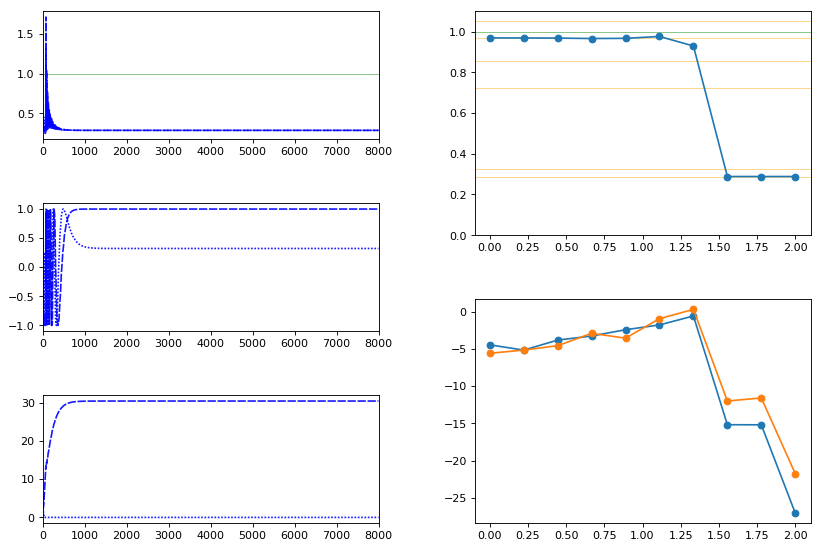

In [8]:
fig, ax = plt.subplots(5, figsize=(12,8), dpi=80)

# Set positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)
ax[4].set_position(bbox4)

# Trial 1:
plot_sol(ax[0], ax[1], ax[2], tarr1, yarr1, yparr1, tauarr1, trial=1)

# Trial 2:
# plot_sol(ax[0], ax[1], ax[2], tarr2, yarr2, yparr2, tauarr2, trial=2)

# Var. frequency + phases vs. logalphatau
ax[3].plot(tr1['alphalogs'], np.log10(tr1['var_Omegas']), marker='o')
ax[3].plot(tr1['alphalogs'], np.log10(tr1['var_phases']), marker='o')

# Convergence frequency vs. logalphatau
ax[4].plot(tr1['alphalogs'], tr1['asy_Omegas'], marker='o')

# Plot horizontal lines
ax[0].axhline(y=w0, zorder=0, **options_w0)
ax[4].axhline(y=w0, zorder=1, **options_w0)

for omega in Omegaroots:
    ax[4].axhline(y=omega, zorder=0, **options_asy)
    
# Adjust
ax[4].set_ylim(bottom=0, top=1.1*w0)

In [9]:
X = tr1['alphatau']
asyOmega = tr1['asy_Omega']
asyDelta = tr1['asy_Delta']
print(f'Statistics: \n alphatau = {X} \n Omega0 = {Omega0} \n Delta0 = {Delta0}')
print(f'asy Omega = {asyOmega} \nasy Delta = {asyDelta}')

Statistics: 
 alphatau = 0.01 
 Omega0 = 0.95 
 Delta0 = 0.2
asy Omega = 0.2882711525045081 
asy Delta = 1.2498006916439337


In [10]:
tarr1.size

4039